# Lab 1: Causal Discovery based Markov Blanket Search

This notebook demonstrates:
1. Loading datasets and visualizing the DAG
2. Introducing Causal Discovery based Markov Blanket Search methods (CD-MB)
   - Evaluating causal discovery performance (NHD, precision, recall, F1)
   - Evaluating Markov Blanket feature selection performance
3. Comparing CD-MB methods

In [ ]:
%load_ext watermark
%watermark -a "Shu Wan" -v

%load_ext autoreload
%autoreload 2

In [ ]:
!pip install -q causal-learn
!pip install -q datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.0/193.0 kB 3.4 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns

# Causal discovery
from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import fisherz
from datasets import load_dataset


from sklearn.metrics import f1_score, precision_score, recall_score
# Set random seed for reproducibility
np.random.seed(42)
sns.set_style('whitegrid')

In [ ]:
# Visualization helpers
def plot_graph(ax, graph, *, target, blanket_nodes=None, default_color="lightblue", title, pos=None):
    """Plot a directed graph highlighting target and Markov blanket nodes."""
    if blanket_nodes is None:
        blanket_nodes = set()
    else:
        blanket_nodes = set(blanket_nodes)

    if pos is None:
        pos = nx.circular_layout(graph)

    node_colors = []
    for node in graph.nodes:
        if node == target:
            node_colors.append("red")
        elif node in blanket_nodes:
            node_colors.append("orange")
        else:
            node_colors.append(default_color)

    nx.draw(
        graph,
        pos,
        ax=ax,
        with_labels=True,
        node_color=node_colors,
        node_size=500,
        font_size=10,
        font_weight="bold",
        arrows=True,
        arrowsize=20,
        edge_color="gray",
    )
    ax.set_title(title, fontsize=12, fontweight="bold")
    return pos


def plot_adjacency_matrix(ax, adj_matrix, *, title):
    """Plot an adjacency matrix with consistent styling."""
    im = ax.imshow(adj_matrix, cmap="binary", aspect="auto")
    n_nodes = adj_matrix.shape[0]
    ax.set_xticks(range(n_nodes))
    ax.set_yticks(range(n_nodes))
    ax.set_xlabel("To Node", fontweight="bold")
    ax.set_ylabel("From Node", fontweight="bold")
    ax.set_title(title, fontsize=12, fontweight="bold")
    return im

## 1. Load Dataset and Read Example

In [ ]:
# Load dataset
datasets = load_dataset("CSE472-blanket-challenge/phase1-dataset", split="train")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

phase1_dataset.jsonl:   0%|          | 0.00/9.86M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/90 [00:00<?, ? examples/s]

In [ ]:
example_idx = 5
example = datasets[example_idx]

print(f"\nSelected example {example_idx}:")
print(f"  Graph ID: {example['graph_id']}")
print(f"  Number of nodes: {example['num_nodes']}")
print(f"  Number of edges: {example['num_edges']}")
print(f"  Density: {example['density']:.4f}")
print(f"  Target variable: {example['target_variable']}")
print(f"  Oracle Markov blanket: {[i for i, x in enumerate(example['markov_blanket']) if x == 1]}")
print(f"  Data shape: {np.array(example['data']).shape}")
print(f"  Method: {example['method']}")


Selected example 5:
  Graph ID: graph_482684d6
  Number of nodes: 10
  Number of edges: 9
  Density: 0.1000
  Target variable: 7
  Oracle Markov blanket: [0, 3, 5, 6, 8, 9]
  Data shape: (500, 10)
  Method: PA


In [ ]:
# Reconstruct the DAG from adjacency matrix
adj_matrix = np.array(example["adjacency_matrix"])
n_nodes = example["num_nodes"]
target = example["target_variable"]
mb = example["markov_blanket"]
oracle_mb = np.where(np.array(mb) == 1)[0].tolist()

# Create NetworkX graph
true_dag = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

## 2. Visualize True DAG and Adjacency Matrix

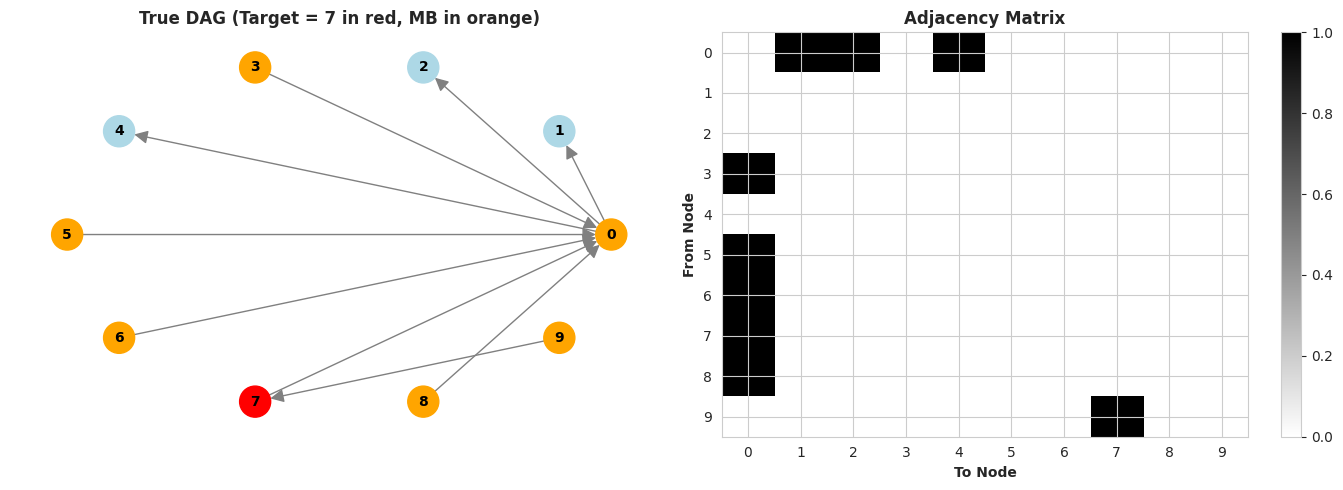

In [ ]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

true_pos = plot_graph(
    axes[0],
    true_dag,
    target=target,
    blanket_nodes=oracle_mb,
    default_color="lightblue",
    title=f"True DAG (Target = {target} in red, MB in orange)",
)

im = plot_adjacency_matrix(
    axes[1],
    adj_matrix,
    title="Adjacency Matrix",
)
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

## 3. Run PC Algorithm for Causal Discovery

We use [causal-learn](https://github.com/py-why/causal-learn)'s PC algorithm in this demo.

You are free to try other packages as well.

In [ ]:
# Prepare data for PC algorithm
data_array = np.array(example["data"])  # Shape: (n_samples, n_nodes)
print(f"Data shape for PC: {data_array.shape}")

# Run PC algorithm
# check https://causal-learn.readthedocs.io/en/latest/search_methods_index/Constraint-based%20causal%20discovery%20methods/PC.html for parameters choice
cg = pc(data_array, alpha=0.05, indep_test=fisherz, stable=True, verbose=False)

discovered_graph = cg.G.graph
# causal-learn represents graph in -1,0,1 format
# convert to 0,1 adjacency matrix
pc_adj = (discovered_graph == 1).astype(int)

Data shape for PC: (500, 10)


  0%|          | 0/10 [00:00<?, ?it/s]

PC returns a class of graph called CPDAG, CPDAG contains undirected edges when the direction cannot be determined from conditional independence tests alone.

There are several ways to resolve the undirected edges
1. one simple way is to randomly assign directions to undirected edges while ensuring no cycles are formed.
2. the other way is to assign both directions, but the graph will no longer be a DAG. For casual feature selection, sometimes it's okay to have redundant edges.

In [ ]:
# is discovered graph a DAG?
discovered_g = nx.from_numpy_array(pc_adj, create_using=nx.DiGraph)
nx.is_directed_acyclic_graph(discovered_g)

True

## 4. Extract Markov Blanket from PC Results

CD-based MB methods recipe

1. Run causal discovery algorithm
2. Resolve the discovered graph if it's not a DAG
3. Extract MB of the target variable from the graph

In [ ]:
# Compute Markov blanket from discovered graph
def find_markov_blanket(adj_matrix, target):
    """Compute Markov blanket: parents + children + co-parents (spouses)."""
    graph = nx.from_numpy_array(adj_matrix, create_using=nx.DiGraph)

    parents = set(graph.predecessors(target))
    children = set(graph.successors(target))

    co_parents = set()
    for child in children:
        co_parents.update(graph.predecessors(child))
    co_parents.discard(target)

    markov_blanket = parents | children | co_parents
    return sorted(markov_blanket)


# Get Markov blankets
pc_mb = find_markov_blanket(pc_adj, target)

print("=== Markov Blanket Comparison ===")
print(f"Target variable: {target}")
print(f"Oracle MB: {oracle_mb}")
print(f"PC-derived MB: {pc_mb}")
print(f"Oracle MB size: {len(oracle_mb)}")
print(f"PC MB size: {len(pc_mb)}")

=== Markov Blanket Comparison ===
Target variable: 7
Oracle MB: [0, 3, 5, 6, 8, 9]
PC-derived MB: [0, 2]
Oracle MB size: 6
PC MB size: 2


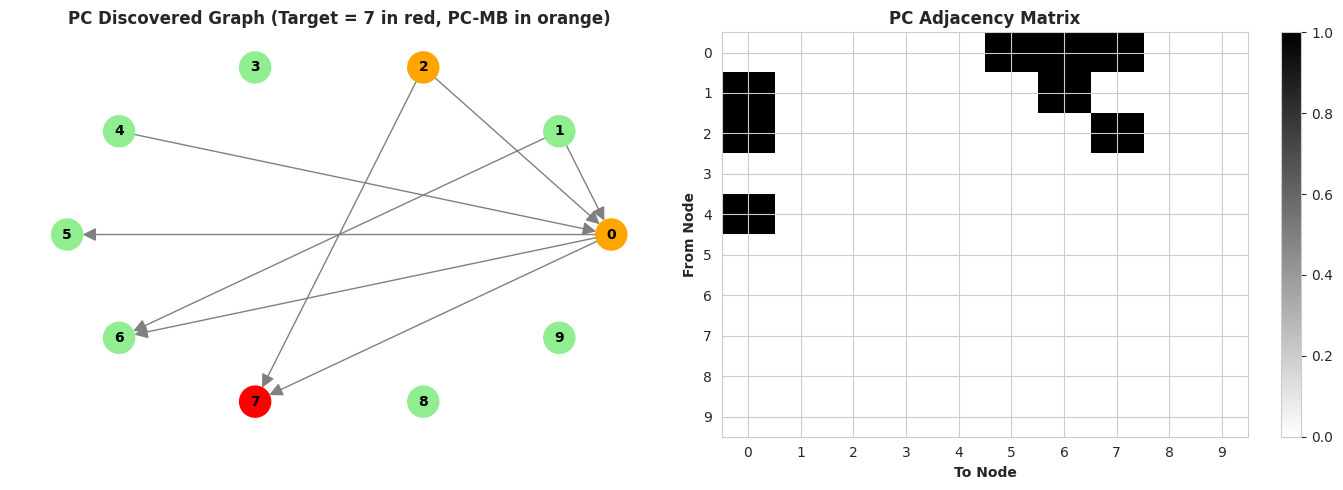

In [ ]:
# Visualize discovered graph
pc_dag = nx.from_numpy_array(pc_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    pc_dag,
    target=target,
    blanket_nodes=pc_mb,
    default_color="lightgreen",
    title=f"PC Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

im = plot_adjacency_matrix(
    axes[1],
    pc_adj,
    title="PC Adjacency Matrix",
)
plt.colorbar(im, ax=axes[1])

plt.tight_layout()
plt.show()

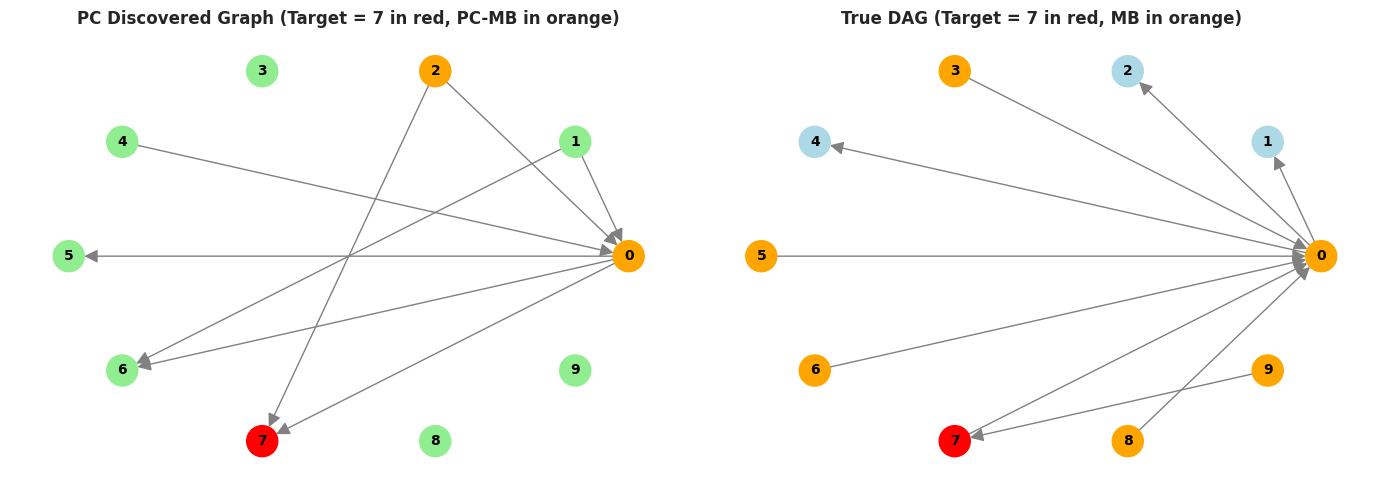

In [ ]:
# compare discoverd graph with true graph
# Visualize discovered graph
pc_dag = nx.from_numpy_array(pc_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plot_graph(
    axes[0],
    pc_dag,
    target=target,
    blanket_nodes=pc_mb,
    default_color="lightgreen",
    title=f"PC Discovered Graph (Target = {target} in red, PC-MB in orange)",
    pos=true_pos,
)

plot_graph(
    axes[1],
    true_dag,
    target=target,
    blanket_nodes=oracle_mb,
    default_color="lightblue",
    title=f"True DAG (Target = {target} in red, MB in orange)",
)

plt.tight_layout()
plt.show()

## 5. Evaluate PC Performance with Metrics

In [ ]:
def calculate_shd(true_adj, pred_adj):
    """Calculate SHD: number of edge additions, deletions, and reversals."""
    n = true_adj.shape[0]
    shd = 0

    for i in range(n):
        for j in range(n):
            if i == j:
                continue

            true_edge = true_adj[i, j]
            pred_edge = pred_adj[i, j]

            # Edge addition or deletion
            if true_edge != pred_edge:
                shd += 1

    return shd // 2  # Divide by 2 since we count each edge twice

# Calculate edge-level precision, recall, F1
def calculate_edge_metrics(true_adj, pred_adj):
    """Calculate precision, recall, F1 for edge prediction using scikit-learn metrics."""
    true_flat = true_adj.reshape(-1)
    pred_flat = pred_adj.reshape(-1)

    precision = precision_score(true_flat, pred_flat, zero_division=0)
    recall = recall_score(true_flat, pred_flat, zero_division=0)
    f1 = f1_score(true_flat, pred_flat, zero_division=0)

    return precision, recall, f1


# Calculate metrics
shd = calculate_shd(adj_matrix, pc_adj)
precision, recall, f1 = calculate_edge_metrics(adj_matrix, pc_adj)

print("=== PC Algorithm Performance ===")
print(f"Structural Hamming Distance (SHD): {shd}")
print(f"Edge Precision: {precision:.3f}")
print(f"Edge Recall: {recall:.3f}")
print(f"Edge F1 Score: {f1:.3f}")
print(f"\nTrue edges: {true_dag.number_of_edges()}")
print(f"Discovered edges: {pc_dag.number_of_edges()}")


=== PC Algorithm Performance ===
Structural Hamming Distance (SHD): 8
Edge Precision: 0.000
Edge Recall: 0.000
Edge F1 Score: 0.000

True edges: 9
Discovered edges: 8


## Your turn

1. Implement at least one other causal discovery method (e.g., GES, FCI)
   1. use one of the packages provided
2. Implement specialized causal feature selection methods (IAMB)
   1. R package bnlearn provide IAMB and fast IAMB implementation. Using [rpy2](https://rpy2.github.io/) or write a R script to run it (if you're familiar with R)

###GES (Greedy Equivalence Search)

=== GES Algorithm Performance ===
Structural Hamming Distance (SHD): 4
Edge Precision: 0.500
Edge Recall: 1.000
Edge F1 Score: 0.667

True edges: 9
Discovered edges (GES): 18


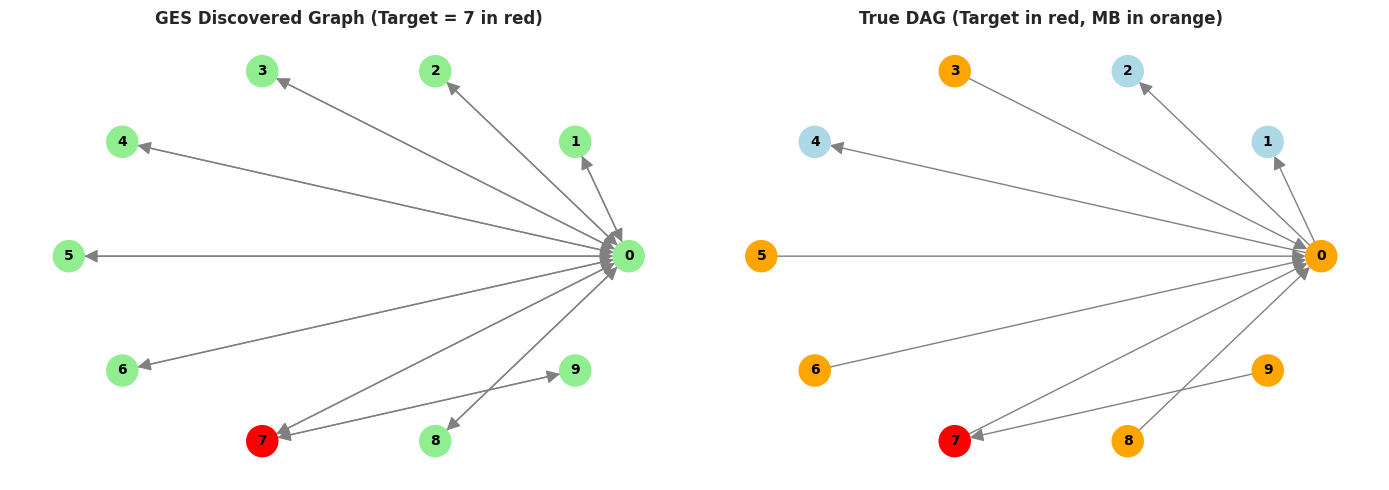

In [ ]:
from causallearn.search.ScoreBased.GES import ges

# run GES on the same data
ges_result = ges(data_array)

# extract the adj matrix
ges_adj = ges_result['G'].graph.copy()
ges_adj = (ges_result['G'].graph != 0).astype(int)

shd_ges = calculate_shd(adj_matrix, ges_adj)
prec_ges, rec_ges, f1_ges = calculate_edge_metrics(adj_matrix, ges_adj)

print("=== GES Algorithm Performance ===")
print(f"Structural Hamming Distance (SHD): {shd_ges}")
print(f"Edge Precision: {prec_ges:.3f}")
print(f"Edge Recall: {rec_ges:.3f}")
print(f"Edge F1 Score: {f1_ges:.3f}")
print(f"\nTrue edges: {true_dag.number_of_edges()}")
print(f"Discovered edges (GES): {np.sum(ges_adj)}")

ges_dag = nx.from_numpy_array(ges_adj, create_using=nx.DiGraph)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_graph(
    axes[0],
    ges_dag,
    target=target,
    default_color="lightgreen",
    title=f"GES Discovered Graph (Target = {target} in red)",
    pos=true_pos,
)
plot_graph(
    axes[1],
    true_dag,
    target=target,
    blanket_nodes=oracle_mb,
    default_color="lightblue",
    title="True DAG (Target in red, MB in orange)",
)
plt.tight_layout()
plt.show()


In [ ]:
ges_mb = find_markov_blanket(ges_adj, target)

print("=== GES Markov Blanket Comparison ===")
print(f"Target variable: {target}")
print(f"Target MB: {oracle_mb}")
print(f"GES-derived MB: {ges_mb}")
print(f"Target size: {len(oracle_mb)}")
print(f"GES size: {len(ges_mb)}")


=== GES Markov Blanket Comparison ===
Target variable: 7
Target MB: [0, 3, 5, 6, 8, 9]
GES-derived MB: [0, 1, 2, 3, 4, 5, 6, 8, 9]
Target size: 6
GES size: 9


In [ ]:
!pip install -q rpy2

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%R -i data_array -i target

In [ ]:
%%R
# Install 'bnlearn' if not already available
if (!require("bnlearn")) install.packages("bnlearn", repos="https://cloud.r-project.org")

library(bnlearn)

# Convert data_array to data frame
data <- as.data.frame(data_array)
target <- as.integer(target) + 1  # R is 1-indexed

# Run IAMB algorithm
cat("Running IAMB on data...\n")
iamb_result <- iamb(data)

# Get Markov Blanket for the selected target variable
target_name <- colnames(data)[target]
mb <- mb(iamb_result, target_name)

cat("Target variable (R index):", target, "\n")
cat("Markov Blanket of", target_name, ":\n")
print(mb)

Running IAMB on data...
Target variable (R index): 9 
Markov Blanket of V9 :
[1] "V1" "V2" "V4" "V6" "V7" "V8"


In [ ]:
# take results back into Python
%Rpull mb

In [ ]:
# Convert to list of strings
mb_py = list(mb)
print("Raw IAMB MB:", mb_py)


Raw IAMB MB: ['V1', 'V2', 'V4', 'V6', 'V7', 'V8']


In [ ]:
# Convert "V1" → 0, "V2" → 1, etc.
iamb_nodes = [int(name[1:]) - 1 for name in mb_py]
print("Converted IAMB MB indices:", iamb_nodes)


Converted IAMB MB indices: [0, 1, 3, 5, 6, 7]


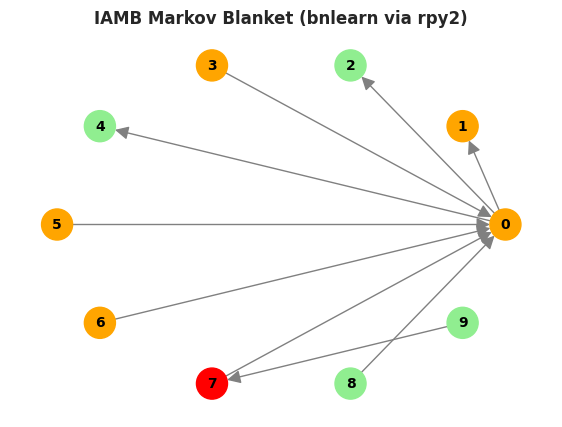

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
plot_graph(
    ax,
    true_dag,
    target=target,
    blanket_nodes=iamb_nodes,
    default_color="lightgreen",
    title="IAMB Markov Blanket (bnlearn via rpy2)"
)
plt.show()


In [ ]:
def calculate_mb_metrics(oracle_mb, discovered_mb, n_nodes):
    """Compute precision, recall, and F1-score for a discovered Markov Blanket."""
    oracle_vec = np.zeros(n_nodes)
    pred_vec = np.zeros(n_nodes)

    oracle_vec[oracle_mb] = 1
    pred_vec[discovered_mb] = 1

    precision = precision_score(oracle_vec, pred_vec, zero_division=0)
    recall = recall_score(oracle_vec, pred_vec, zero_division=0)
    f1 = f1_score(oracle_vec, pred_vec, zero_division=0)
    return precision, recall, f1

prec_iamb, rec_iamb, f1_iamb = calculate_mb_metrics(oracle_mb, iamb_nodes, n_nodes)

print("=== IAMB Algorithm (bnlearn via rpy2) ===")
print(f"Markov Blanket Precision: {prec_iamb:.3f}")
print(f"Markov Blanket Recall:    {rec_iamb:.3f}")
print(f"Markov Blanket F1-score:  {f1_iamb:.3f}")
print(f"\nTrue MB size: {len(oracle_mb)} | IAMB MB size: {len(iamb_nodes)}")
print(f"Oracle MB: {oracle_mb}")
print(f"IAMB MB:   {iamb_nodes}")

=== IAMB Algorithm (bnlearn via rpy2) ===
Markov Blanket Precision: 0.667
Markov Blanket Recall:    0.667
Markov Blanket F1-score:  0.667

True MB size: 6 | IAMB MB size: 6
Oracle MB: [0, 3, 5, 6, 8, 9]
IAMB MB:   [0, 1, 3, 5, 6, 7]


## Questions

1. Can PC or CD in general recover the DAG well?
   1. If not, what do you observe? Can you improve it by adjusting hyperparameters?
   2. If not, what's your hypothesis?
2. What's the relationship of size of Markov Blanket (w.r.t total nodes) and density of the graph?
3. Is dedicated causal feature selection method (IAMB) working better than causal discovery methods?

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score

X = np.array(example['data'])
y = X[:, target]
X = np.delete(X, target, axis=1)  # remove target column from features
feature_indices = np.arange(X.shape[1])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

def evaluate_features(X, y, selected_idx, name=None, verbose=False):
    """
    Train linear regression on selected features and evaluate performance.

    Parameters
    ----------
    X : np.ndarray
        Feature matrix.
    y : np.ndarray
        Target vector.
    selected_idx : list or array
        Indices of selected features.
    name : str, optional
        Label for printing results.
    verbose : bool, default=True
        Whether to print results.

    Returns
    -------
    rmse : float
        Root mean squared error.
    r2 : float
        R² score.
    """
    if selected_idx is None or len(selected_idx) == 0:
        if verbose and name:
            print(f"{name:25s} | #Features:  0 | RMSE:   nan | R²:   nan")
        return np.nan, np.nan

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X[:, selected_idx], y, test_size=0.2, random_state=42
    )

    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Compute metrics
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    # Optionally print
    if verbose:
        name_str = name if name else "Model"
        print(f"{name_str:25s} | #Features: {len(selected_idx):2d} | RMSE: {rmse:.3f} | R²: {r2:.3f}")

    return rmse, r2

In [ ]:
results = {}

# (A) No Feature Selection — use all features
results["All Features"] = evaluate_features(X, y, np.arange(X.shape[1]), "All Features")

# (B) Filter method — e.g., SelectKBest (non-causal)
k = len(oracle_mb)  # same number of features as true MB
filter_selector = SelectKBest(f_regression, k=k)
filter_selector.fit(X_train, y_train)
filter_idx = np.where(filter_selector.get_support())[0]
results["Filter (f_regression)"] = evaluate_features(X, y, filter_idx, "Filter (f_regression)")

# (C) Embedded method — LASSO
lasso = Lasso(alpha=0.05).fit(X_train, y_train)
lasso_idx = np.where(lasso.coef_ != 0)[0]
results["Lasso"] = evaluate_features(X, y, lasso_idx, "Lasso")

# (D) Oracle MB (ground truth)
oracle_features = [i if i < target else i - 1 for i in oracle_mb]
results["Oracle MB"] = evaluate_features(X, y, oracle_features, "Oracle MB")


In [ ]:
from rpy2.robjects import r, pandas2ri
from tqdm import tqdm
import numpy as np

pandas2ri.activate()

iamb_results = []

for ex in tqdm(datasets):
    X = np.array(ex['data'])
    target = int(ex['target_variable'])
    oracle_mb = np.where(np.array(ex['markov_blanket']) == 1)[0].tolist()

    # Assign to R
    r.assign("data_array", X)
    r('data <- as.data.frame(data_array)')
    n_cols = X.shape[1]
    r(f'colnames(data) <- paste0("V", 1:{n_cols})')

    r.assign("target", target + 1)
    r('library(bnlearn)')

    try:
        r('suppressWarnings({'
      '  iamb_result <- iamb(data);'
      '  target_name <- colnames(data)[target];'
      '})')
        mb = list(r('mb(iamb_result, target_name)'))
        iamb_indices = [int(name[1:]) - 1 for name in mb]
    except Exception as e:
        print(f"⚠️ Error on example {ex['graph_id']}: {e}")
        iamb_indices = []

    iamb_results.append({
        "graph_id": ex["graph_id"],
        "oracle_mb": oracle_mb,
        "iamb_indices": iamb_indices

    })

100%|██████████| 90/90 [00:23<00:00,  3.78it/s]


In [ ]:
iamb_dict = {r["graph_id"]: r["iamb_indices"] for r in iamb_results}

first_key, first_value = list(iamb_dict.items())[0]

# print an example
print(first_key, first_value)

graph_cb533667 [0, 2, 5, 7, 9]


In [ ]:
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Store results
methods = ["All", "Filter", "Lasso", "Oracle"]
results = {m: {"rmse": [], "r2": []} for m in methods}

# Loop over all examples
for ex in tqdm(datasets):
    X = np.array(ex['data'])
    target = ex['target_variable']
    y = X[:, target]
    X = np.delete(X, target, axis=1)
    n_features = X.shape[1]
    oracle_mb = np.where(np.array(ex['markov_blanket']) == 1)[0].tolist()

    # --- (A) All features ---
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_all = LinearRegression().fit(X_train, y_train)
    y_pred = model_all.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results["All"]["rmse"].append(rmse)
    results["All"]["r2"].append(r2)

    # --- (B) Filter method ---
    k = len(oracle_mb)
    if k > 0:
        selector = SelectKBest(f_regression, k=k).fit(X, y)
        f_idx = np.where(selector.get_support())[0]
        X_train, X_test, y_train, y_test = train_test_split(X[:, f_idx], y, test_size=0.2, random_state=42)
        model_filter = LinearRegression().fit(X_train, y_train)
        y_pred = model_filter.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        results["Filter"]["rmse"].append(rmse)
        results["Filter"]["r2"].append(r2)

    # --- (C) LASSO with scaling and higher iterations ---
    lasso_pipe = make_pipeline(StandardScaler(), Lasso(alpha=0.05, max_iter=5000))
    lasso_pipe.fit(X, y)
    lasso = lasso_pipe.named_steps["lasso"]
    lasso_idx = np.where(lasso.coef_ != 0)[0]

    if len(lasso_idx) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X[:, lasso_idx], y, test_size=0.2, random_state=42)
        model_lasso = LinearRegression().fit(X_train, y_train)
        y_pred = model_lasso.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    else:
        rmse, r2 = np.nan, np.nan

    results["Lasso"]["rmse"].append(rmse)
    results["Lasso"]["r2"].append(r2)

    # --- (D) Oracle MB ---
    oracle_features = [i if i < target else i - 1 for i in oracle_mb]
    if len(oracle_features) > 0:
        X_train, X_test, y_train, y_test = train_test_split(X[:, oracle_features], y, test_size=0.2, random_state=42)
        model_oracle = LinearRegression().fit(X_train, y_train)
        y_pred = model_oracle.predict(X_test)
        rmse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
    else:
        rmse, r2 = np.nan, np.nan
    results["Oracle"]["rmse"].append(rmse)
    results["Oracle"]["r2"].append(r2)

# --- Compute mean performance ---
print("\n=== Average Results Across All Examples ===")
for method in methods:
    if len(results[method]["rmse"]) == 0:
        continue
    avg_rmse = np.nanmean(results[method]["rmse"])
    avg_r2 = np.nanmean(results[method]["r2"])
    print(f"{method:15s} | RMSE: {avg_rmse:8.3f} | R²: {avg_r2:6.3f}")

100%|██████████| 90/90 [00:01<00:00, 65.81it/s]


=== Average Results Across All Examples ===
All             | RMSE: 1832.497 | R²:  0.688
Filter          | RMSE: 2282.475 | R²:  0.653
Lasso           | RMSE: 1829.213 | R²:  0.688
Oracle          | RMSE: 1796.759 | R²:  0.696


In [ ]:
for m in results:
    print(m, np.nanmean(results[m]["rmse"]))

All 1832.4970631879007
Filter 2282.474550161581
Lasso 1832.4940345274863
Oracle 1796.759325897121
